****

# **RSNA Breast Cancer**

**The purpose of preprocessing images is to prepare them for further analysis or processing,
such as machine learning or computer vision tasks. 
This may involve tasks such as resizing, cropping,
normalizing, or converting the images to a different format. 
Preprocessing can also involve removing noise or artifacts from the images,
or performing image enhancement to improve the visibility or contrast of certain features.
The specific preprocessing steps used will depend on the task at hand and the type of images being used.**

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tf-efficientnet-condconv/pytorch/tf-efficientnet-cc-b0-4e/1/tf_efficientnet_cc_b0_4e-4362b6b2.pth
/kaggle/input/rsna-breast-cancer-detection/sample_submission.csv
/kaggle/input/rsna-breast-cancer-detection/train.csv
/kaggle/input/rsna-breast-cancer-detection/test.csv
/kaggle/input/rsna-breast-cancer-detection/train_images/10706/763186195.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/10706/937109986.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/10706/34700621.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/10706/1167990339.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/21867/1291014447.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/21867/831671840.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/21867/1481837831.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/21867/851000290.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/34867/1724313070.dcm
/kaggle/input/rsna-breast-cance

In [4]:
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/working/__notebook_source__.ipynb


# Importing Libaries

I have used Grassroots (**python-gdcm**)  DiCoM is a C++ library for DICOM medical files that can be wrapped for Python using **SWIG**. It supports datasets encoded using native, JPEG, JPEG 2000, JPEG-LS, RLE and deflated transfer syntaxes. It also comes with Parts 3, 6 & 7 of the DICOM Standard as XML files. 

(**pydicom**)Dicom (Digital Imaging in Medicine) is the bread and butter of medical image datasets, storage and transfer. This is the future home of the Pydicom documentation

**Pylibjpeg** is a Python wrapper for the libjpeg library, which is a widely-used open-source implementation of the JPEG image compression standard. Pylibjpeg allows Python developers to access the functionality of libjpeg, such as reading and writing JPEG image files, through a Pythonic API. It can be used for tasks such as image processing, computer vision, and web development.

**DICOM (Digital Imaging and Communications in Medicine)** files. The package is built on top of pydicom, which is a pure Python package for reading and writing DICOM files. **dicomsdl package provides additional functionality such as support for working with compressed DICOM files**, and support for working with DICOM files that use the JPEG 2000, JPEG-LS and RLE compression

**tqdm** is a Python library for **creating progress bars and visualizing progress** in the command line. It can be used to monitor the progress of loops, iterators, and other operations that take a significant amount of time to complete. The library is designed to be very simple to use, and it can be integrated into existing Python code with minimal modifications.

**tqdm.trange(n)** is a function from the tqdm library, which is a shorthand for tqdm(range(n)). **It creates an instance of the tqdm class that wraps a range(n) object, and the iterator returned by this class is a tqdm-aware iterator**. This means that it will display a progress bar, showing the current iteration, the total number of iterations, and the percentage complete.

In [1]:
!pip install -qU python-gdcm pydicom pylibjpeg
!pip install -qU dicomsdl

import os
import time
import cv2
import pydicom
import dicomsdl
import seaborn as sns

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange         
from joblib import Parallel, delayed

**Data Paths**

In [5]:
csv_path = '/kaggle/input/rsna-breast-cancer-detection/train.csv'
train_path = '/kaggle/input/rsna-breast-cancer-detection/train_images'
data = pd.read_csv(csv_path)
len(data)

54706



  This section includes utility functions that are used in the notebook.

*     **get_paths:** prepare the inputs of the MammographyPreprocessor methods
*     **calculate_aspect_ratios:** preprocessing resizing shape decision support tool



In [6]:
def get_paths(n: int=len(data), shuffle: bool=False):
    if shuffle == True:
        df = data.sample(frac=1, random_state=0)
    else:
        df = data
    paths = []
    ids_cache = []
    for i in range(n):
        patient = str(df.iloc[i]['patient_id'])
        scan = str(df.iloc[i]['image_id'])
        paths.append(train_path + '/' + patient + '/' + scan + '.dcm')
        ids_cache.append({'patient_id': patient, 'scan_id': scan})
    return paths, ids_cache


# Example
paths, _ = get_paths(n=5, shuffle=True)
paths

['/kaggle/input/rsna-breast-cancer-detection/train_images/58224/132390955.dcm',
 '/kaggle/input/rsna-breast-cancer-detection/train_images/21809/1307476428.dcm',
 '/kaggle/input/rsna-breast-cancer-detection/train_images/58351/1689606258.dcm',
 '/kaggle/input/rsna-breast-cancer-detection/train_images/60826/1465194139.dcm',
 '/kaggle/input/rsna-breast-cancer-detection/train_images/1250/1329687627.dcm']

***Missing Data***

In [7]:
data.sum()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


site_id                                                                79893
patient_id                                                        1788824123
image_id                                                      59048889841940
laterality                 LLRRLLRRLLRRLLRRLLLRRLLRRLLLRRRLLRRLLRRLLRRLLR...
view                       CCMLOMLOCCCCMLOCCMLOCCMLOCCMLOMLOCCMLOCCCCMLOM...
age                                                                3200538.0
cancer                                                                  1158
biopsy                                                                  2969
invasive                                                                 818
BIRADS                                                               20302.0
implant                                                                 1477
machine_id                                                           2987953
difficult_negative_case                                                 7705

In [8]:
data.isna().sum()

site_id                        0
patient_id                     0
image_id                       0
laterality                     0
view                           0
age                           37
cancer                         0
biopsy                         0
invasive                       0
BIRADS                     28420
implant                        0
density                    25236
machine_id                     0
difficult_negative_case        0
dtype: int64

In [9]:
num_patients = data['patient_id'].nunique()
print(f"There are {num_patients} different patients ")

There are 11913 different patients 


# Age Distribution

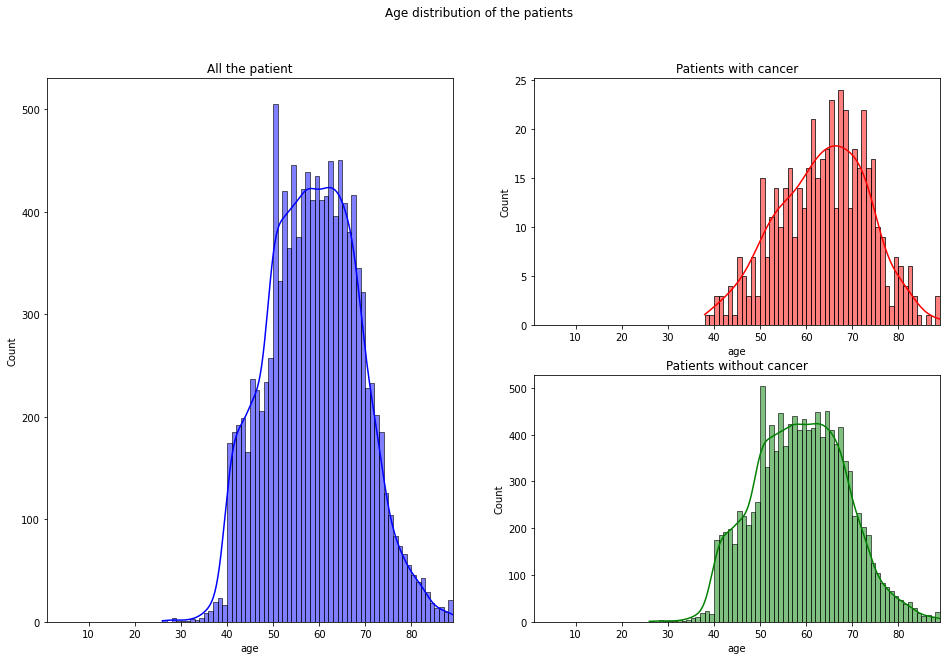

In [10]:
ages = data.groupby('patient_id')['age'].apply(lambda x: x.unique()[0])
cancer_ages = data[data['cancer'] == 1].groupby('patient_id')['age'].apply(lambda x: x.unique()[0])
no_cancer_ages = data[data['cancer'] == 0].groupby('patient_id')['age'].apply(lambda x: x.unique()[0])

plt.figure(figsize=(16, 10))

plt.subplot(1, 2, 1)
sns.histplot(ages, bins=63, color='blue', kde=True)
plt.title("All the patient")
plt.xlim(1, 89)

plt.subplot(2, 2, 2)
sns.histplot(cancer_ages, bins=51, color='red', kde=True)
plt.title("Patients with cancer")
plt.xlim(1, 89)

plt.subplot(2, 2, 4)
sns.histplot(no_cancer_ages, bins=63, color='green', kde=True)
plt.title("Patients without cancer")
plt.xlim(1, 89)

plt.suptitle("Age distribution of the patients")
plt.show()

In [11]:
def calculate_aspect_ratios(paths: list, preprocessor=None):
    ratios = []
    for i in trange(len(paths)):
        if preprocessor:
            img = preprocessor.preprocess_single_image(paths[i])
        else:
            scan = pydicom.dcmread(paths[i])
            img = scan.pixel_array
        height, width = img.shape
        ratio = height / width
        ratios.append(ratio)
    return ratios


# Example
ratios = calculate_aspect_ratios(paths)
print("Ratios:", ratios)
print("Min:", np.min(ratios))
print("Max:", np.max(ratios))
print("Avg:", np.mean(ratios))
print("Avg:", np.total(ratios))

  0%|          | 0/5 [00:00<?, ?it/s]

Ratios: [1.3, 1.1985370950888192, 1.2307692307692308, 1.279030910609858, 1.0895218718209563]
Min: 1.0895218718209563
Max: 1.3
Avg: 1.219571821657773


AttributeError: module 'numpy' has no attribute 'total'

The steps for a single image are the following:

* **Windowing:** improve the contrast of images the way they are intended to be viewed
* **Fix the photometric interpretation:** set all image backgrounds to zero
* **Rescale with slope and intercept:** it seems like it is not necessary but just in   case
* **Normalize between 0 and 255:** convert to 8-bits pixel values, grayscale
* **Flip the breasts:** flip the breasts on the same side for more consistency
* **Crop the background:** remove extra background
* **Resize:** make all images the same size for the future model
* **Save the image:** PNG default, JPEG optional


In [15]:
class MammographyPreprocessor():
    
    # Constructor
    def __init__(self, size: tuple=None, breast_side: str='L',
                 csv_path=None, train_path=None):
        self.size = size
        os.makedirs(os.getcwd(), exist_ok=True)
        self.breast_side = breast_side
        assert breast_side in ['L', 'R'], "breast_side should be 'L' or 'R'"
        # implement the paths of the original RSNA dataset (V2)
        self.csv_path = '/kaggle/input/rsna-breast-cancer-detection/train.csv'
        self.train_path = '/kaggle/input/rsna-breast-cancer-detection/train_images'
        if csv_path:
            self.csv_path = csv_path
        if train_path:
            self.train_path = train_path
        self.df = pd.read_csv(self.csv_path)
        self.save_root = os.getcwd()
    
    # Get the paths from the preprocessor (V2)
    def get_paths(self, n: int=None, shuffle: bool=False, return_cache: bool=False):
        if n == None:
            n = len(self.df)
        if shuffle == True:
            df = self.df.sample(frac=1, random_state=0).copy()
        else:
            df = self.df.copy()
        paths = []
        ids_cache = []
        for i in range(n):
            patient = str(df.iloc[i]['patient_id'])
            scan = str(df.iloc[i]['image_id'])
            paths.append(self.train_path + '/' + patient + '/' + scan + '.dcm')
            ids_cache.append({'patient_id': patient, 'scan_id': scan})
        if return_cache:
            return paths, ids_cache
        else:
            return paths
    
    # Read from a path and convert to image array
    def read_image(self, path: str):
        scan = pydicom.dcmread(path)
        img = scan.pixel_array
        return img
    
    # Apply the preprocessing methods on one image
    def preprocess_single_image(self, path: str, save: bool=False,
                                save_dir: str=None, png: bool=True):
        scan = dicomsdl.open(path)
        img = scan.pixelData()
        img = self._fix_photometric_interpretation(img, scan)
        img = self._windowing(img, scan)
        img = self._normalize_to_255(img)
        img = self._flip_breast_side(img, scan)
        img = self._crop(img)
        if self.size:
            img = self._resize(img)
        if save:
            self._save_image(img, path, png, save_dir)
        return img
    
    # Preprocess all the images from the paths
    def preprocess_all(self, paths: list, save: bool=True,
                       save_dir: str='train_images', png: bool=True,
                       parallel: bool=False, n_jobs: int=4):
        clock = time.time()
        if parallel:
            Parallel(n_jobs=n_jobs) \
            (delayed(self.preprocess_single_image) \
            (path, save, save_dir, png) for path in tqdm(paths, total=len(paths)))
            print("Parallel preprocessing done!")
        else:
            for i in trange(len(paths)):
                self.preprocess_single_image(paths[i], save, save_dir, png)
            print("Sequential preprocessing done!")
        print("Time =", np.around(time.time() - clock, 3), 'sec')
    
    # Display the images from the dicom paths with optional preprocessing
    def display(self, paths: list, rows: int, cols: int,
                preprocess: bool=False, cmap='bone', cbar: bool=False,
                save_fig: bool=False, save_name: str='myplot.png'):
        assert len(paths) >= (rows * cols), \
        f"Not enough paths for the display. " \
        f"Please give at least {rows * cols} paths."
        plt.figure(figsize=(18, 26 * rows / cols))
        for i in trange(rows * cols):
            path = paths[i]
            if preprocess:
                img = self.preprocess_single_image(path, save=False)
            else:
                img = self.read_image(path)
            plt.subplot(rows, cols, i+1)
            plt.imshow(img, cmap=cmap)
            if cbar:
                plt.colorbar()
            plt.grid(False)
            plt.title(path.split('/')[-1][:-4])
        plt.suptitle("Preprocessed images" if preprocess \
                     else "Raw images", fontsize=25)
        if save_fig:
            plt.savefig(save_name, facecolor='white')
        plt.show()
    
    # Adjust the contrast of an image
    def _windowing(self, img, scan):
        function = scan.VOILUTFunction
        if type(scan.WindowWidth) == list:
            center = scan.WindowCenter[0]
            width = scan.WindowWidth[0]
        else:
            center = scan.WindowCenter
            width = scan.WindowWidth
        y_range = 2**scan.BitsStored - 1
        if function == 'SIGMOID':
            img = y_range / (1 + np.exp(-4 * (img - center) / width))
        else: # LINEAR
            below = img <= (center - width / 2)
            above = img > (center + width / 2)
            between = np.logical_and(~below, ~above)
            img[below] = 0
            img[above] = y_range
            img[between] = ((img[between] - center) / width + 0.5) * y_range
        return img
    
    # Interpret pixels in a consistant way
    def _fix_photometric_interpretation(self, img, scan):
        if scan.PhotometricInterpretation == 'MONOCHROME1':
            return img.max() - img
        elif scan.PhotometricInterpretation == 'MONOCHROME2':
            return img - img.min()
        else:
            raise ValueError("Invalid Photometric Interpretation: {}"
                               .format(scan.PhotometricInterpretation))
    
    # Cast into 8-bits for saving
    def _normalize_to_255(self, img):
        if img.max() != 0:
            img = img / img.max()
        img *= 255
        return img.astype(np.uint8)
    
    # Flip the breast horizontally on the chosen side 
    def _flip_breast_side(self, img, scan):
        img_breast_side = self._determine_breast_side(img)
        if img_breast_side == self.breast_side:
            return img
        else:
            return np.fliplr(img)    
    
    # Determine the current breast side
    def _determine_breast_side(self, img):
        col_sums_split = np.array_split(np.sum(img, axis=0), 2)
        left_col_sum = np.sum(col_sums_split[0])
        right_col_sum = np.sum(col_sums_split[1])
        if left_col_sum > right_col_sum:
            return 'L'
        else:
            return 'R'
    
    # Crop the useless background of the image
    def _crop(self, img):
        bin_img = self._binarize(img, threshold=5)
        contour = self._extract_contour(bin_img)
        img = self._erase_background(img, contour)
        x1, x2 = np.min(contour[:, :, 0]), np.max(contour[:, :, 0])
        y1, y2 = np.min(contour[:, :, 1]), np.max(contour[:, :, 1])
        x1, x2 = int(0.99 * x1), int(1.01 * x2)
        y1, y2 = int(0.99 * y1), int(1.01 * y2)
        return img[y1:y2, x1:x2]
    
    # Binarize the image at the threshold
    def _binarize(self, img, threshold):
        return (img > threshold).astype(np.uint8)
    
    # Get contour points of the breast
    def _extract_contour(self, bin_img):
        contours, _ = cv2.findContours(
            bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contour = max(contours, key=cv2.contourArea)
        return contour
    
    # Set to background pixels of the image to zero
    def _erase_background(self, img, contour):
        mask = np.zeros(img.shape, np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
        output = cv2.bitwise_and(img, mask)
        return output
    
    # Resize the image to the preprocessor size
    def _resize(self, img):
        return cv2.resize(img, self.size)
    
    # Get the save path of a given dicom file
    def _get_save_path(self, path, png, save_dir):
        patient = path.split('/')[-2]
        filename = path.split('/')[-1]
        if png:
            filename = filename.replace('dcm', 'png')
        else:
            filename = filename.replace('dcm', 'jpeg')
        if save_dir:
            save_path = os.path.join(self.save_root, save_dir, patient, filename)
        else:
            save_path = os.path.join(self.save_root, patient, filename)
        return save_path
    
    # Save the preprocessed image
    def _save_image(self, img, path, png, save_dir):
        save_path = self._get_save_path(path, png, save_dir)
        patient_folder = os.path.split(save_path)[0]
        os.makedirs(patient_folder, exist_ok=True)
        cv2.imwrite(save_path, img)

In [21]:
# Test with total files files 
paths, _ = get_paths(n=100, shuffle=True)

In [22]:
mp = MammographyPreprocessor(size=(256, 256))
mp

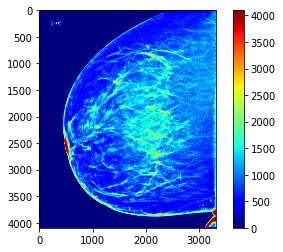

In [25]:
# Select the first file of the list
path = paths[22]

# Load the image array
img = mp.read_image(path=path)

# Display what has been loaded
plt.imshow(img, cmap='jet')
plt.colorbar()
plt.show()

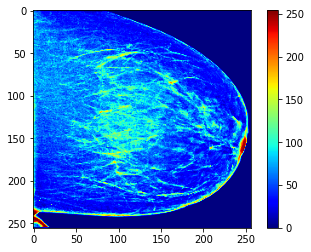

In [26]:
# Preprocess from the same previous path
img = mp.preprocess_single_image(path=path, save=False)

# Display the preprocessed image
plt.imshow(img, cmap='jet')
plt.colorbar()
plt.show()

# **Displaying**

***Before Preprocessing***

In [27]:
mp.preprocess_all(paths, save=True, save_dir='train_images', parallel=True, n_jobs=4)

  0%|          | 0/100 [00:00<?, ?it/s]

Parallel preprocessing done!
Time = 64.755 sec


  0%|          | 0/20 [00:00<?, ?it/s]

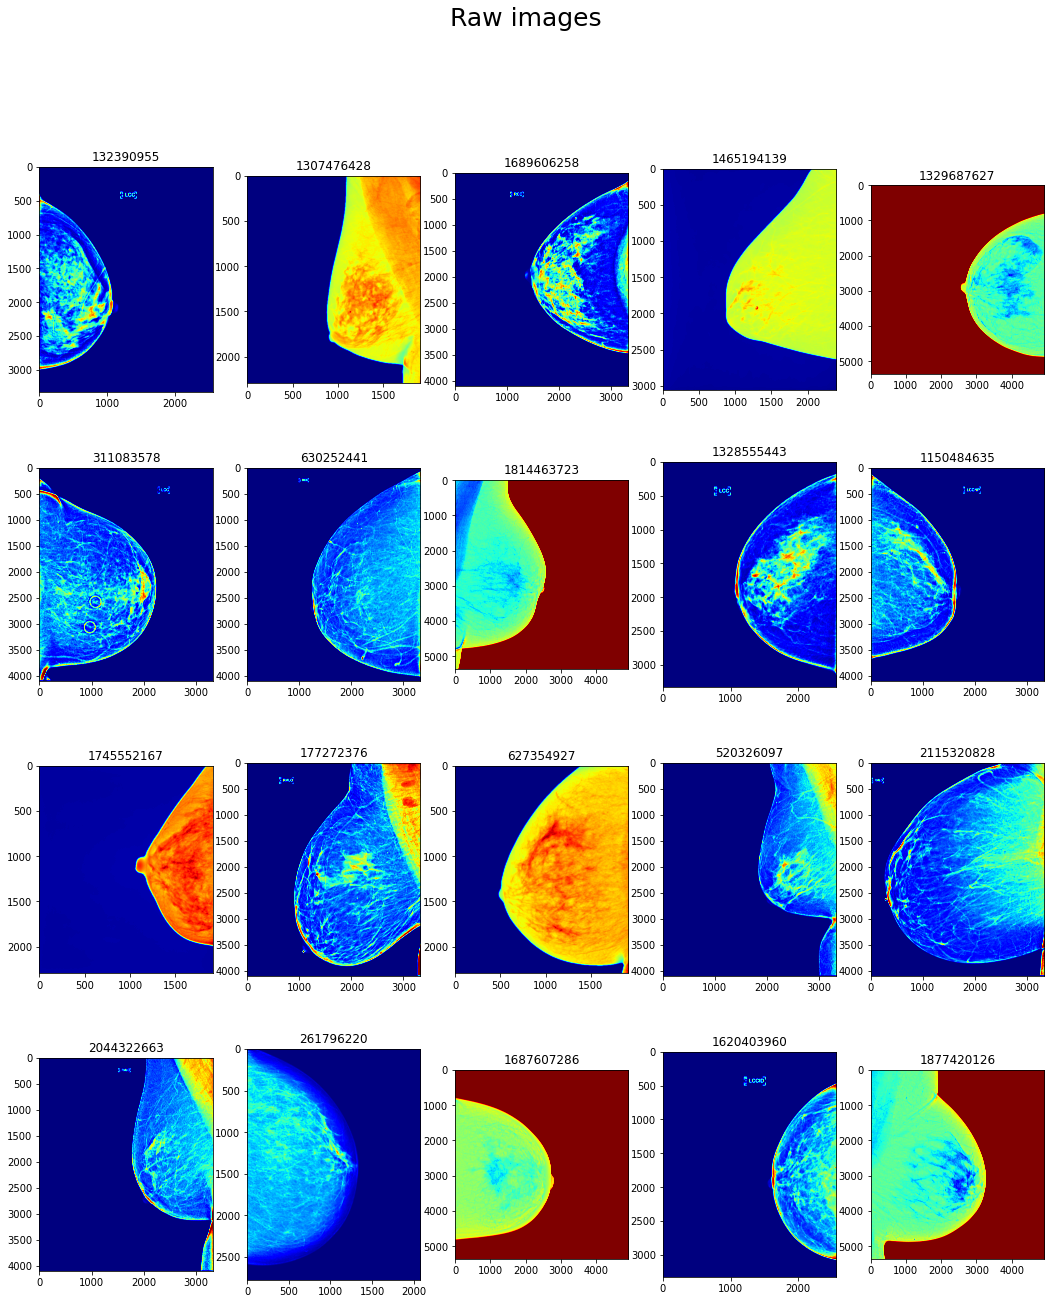

In [28]:
# Images before preprocessing
mp.display(paths, rows=4, cols=5, preprocess=False, cmap='jet', save_fig=False)

***After Preprocessing***

  0%|          | 0/15 [00:00<?, ?it/s]

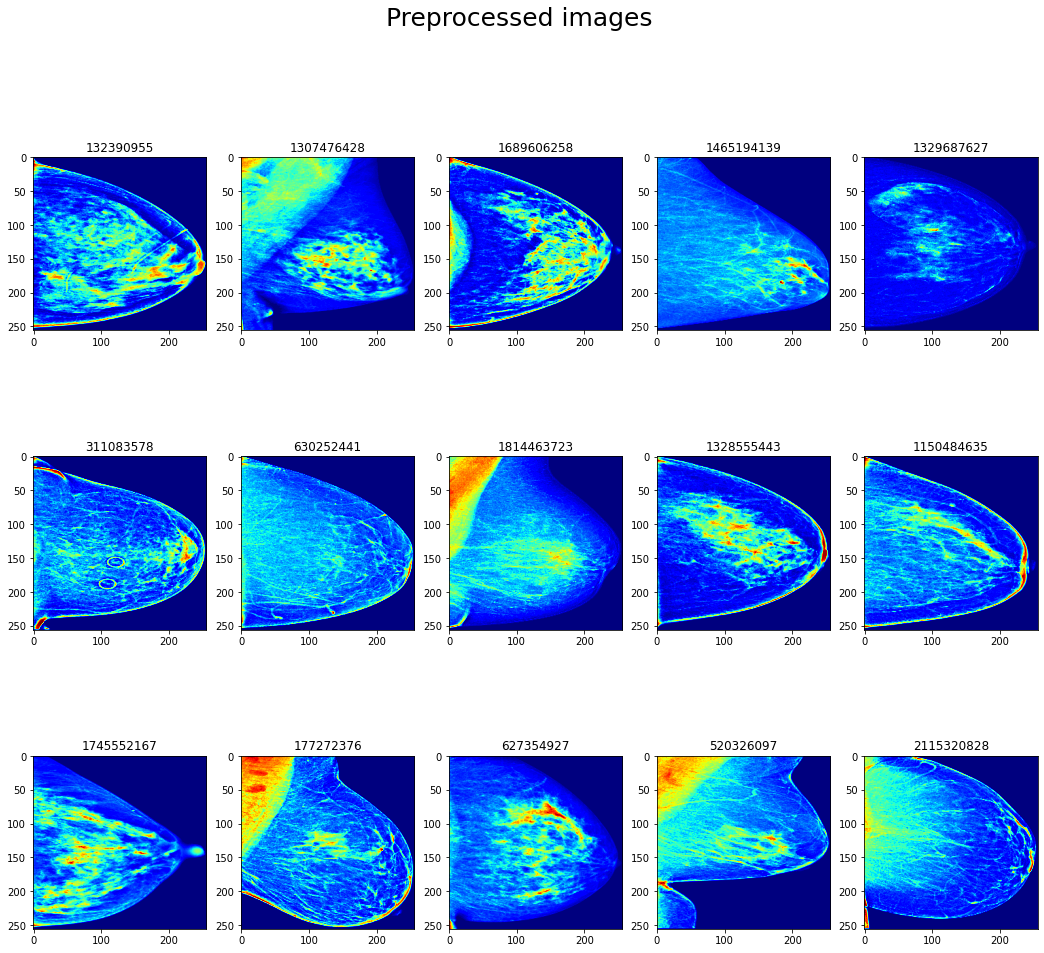

In [29]:
# Images after preprocessing
mp.display(paths, rows=3, cols=5, preprocess=True, cmap='jet', save_fig=False)

# ***calculate the average size ratio of several breast***

In [30]:
# Get more file paths
paths, _ = get_paths(n=300, shuffle=True)

# Create a new preprocessor with no resize value
mp = MammographyPreprocessor()

# Calculate the size ratios with the preprocessor
ratios = calculate_aspect_ratios(paths, preprocessor=mp)
print("Min ratio:", np.min(ratios))
print("Max ratio:", np.max(ratios))
print("Med ratio:", np.median(ratios))

  0%|          | 0/300 [00:00<?, ?it/s]

Min ratio: 1.2772277227722773
Max ratio: 4.713375796178344
Med ratio: 2.096771760813507


***There might be horizontal distortion in previous images To minimize this effect, it might be helpful to resize the images into a shape that is closer to their median aspect ratio, which appears to be around 2. Possible resize dimensions that could achieve this might include 128x256, 256x512, or 512x1024.***

  0%|          | 0/15 [00:00<?, ?it/s]

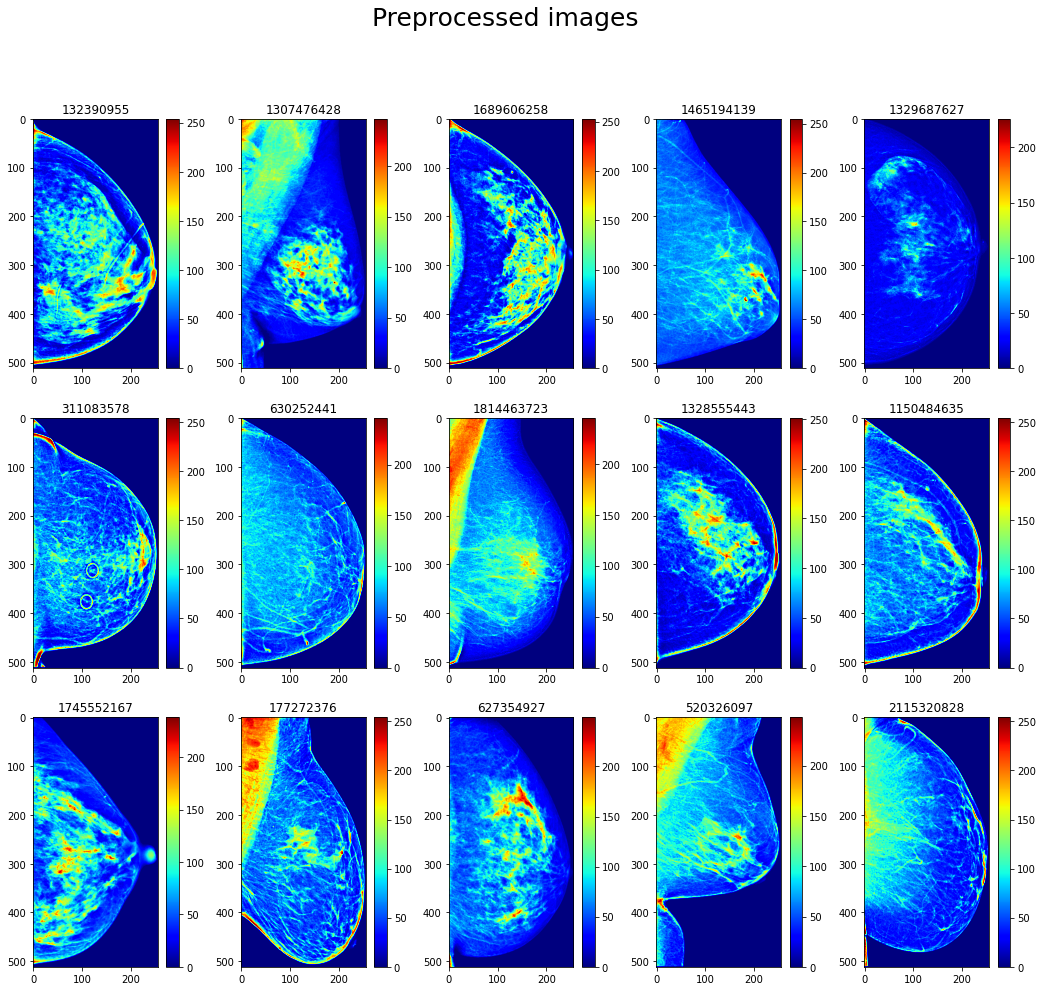

In [31]:


# Define first the new size value
mp = MammographyPreprocessor(size=(256, 512)) # OpenCV convention (Width x Height)
mp.display(paths, rows=3, cols=5, preprocess=True, cmap='jet', cbar=True, save_fig=False)



TypeError: Image data of dtype <U38 cannot be converted to float

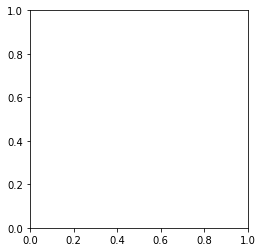

In [32]:
k='/kaggle/working/train_images/27800.dcm'
plt.imshow(k, cmap='jet')
plt.colorbar()
plt.show()

# Number of images per patient

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


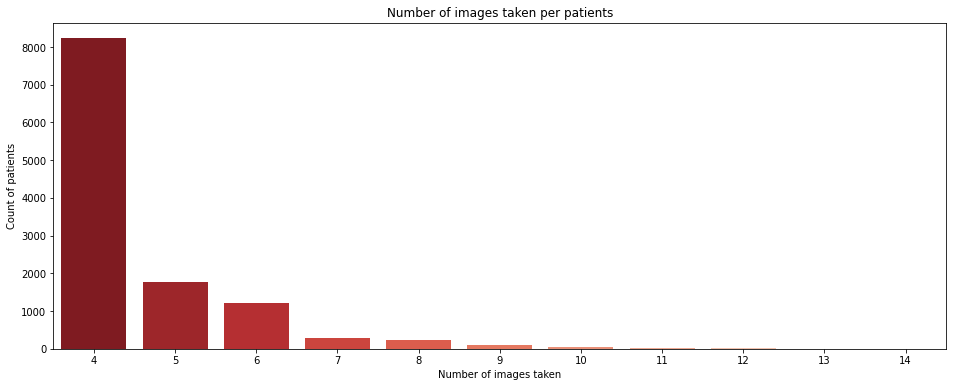

In [33]:


n_images_per_patient = data['patient_id'].value_counts()
plt.figure(figsize=(16, 6))
sns.countplot(n_images_per_patient, palette='Reds_r')
plt.title("Number of images taken per patients")
plt.xlabel('Number of images taken')
plt.ylabel('Count of patients')
plt.show()



**Image Featuring**

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn

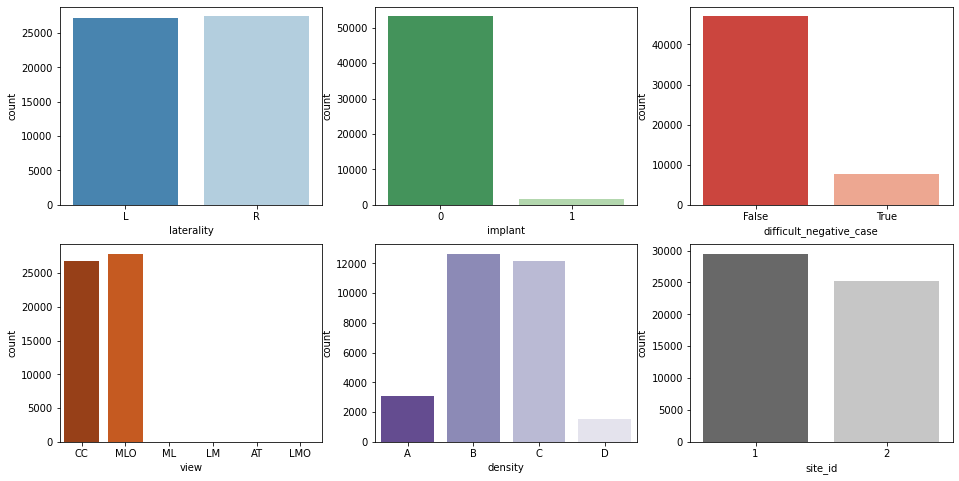

In [34]:
fig, ax = plt.subplots(2, 3, figsize=(16, 8))
sns.countplot(data['laterality'], palette='Blues_r', ax=ax[0, 0])
sns.countplot(data['implant'], palette='Greens_r', ax=ax[0, 1])
sns.countplot(data['difficult_negative_case'], palette='Reds_r', ax=ax[0, 2])
sns.countplot(data['view'], palette='Oranges_r', ax=ax[1, 0])
sns.countplot(data['density'], palette='Purples_r', order=['A', 'B', 'C', 'D'], ax=ax[1, 1])
sns.countplot(data['site_id'], palette='Greys_r', ax=ax[1, 2])
plt.show()

**Machine IDs**

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


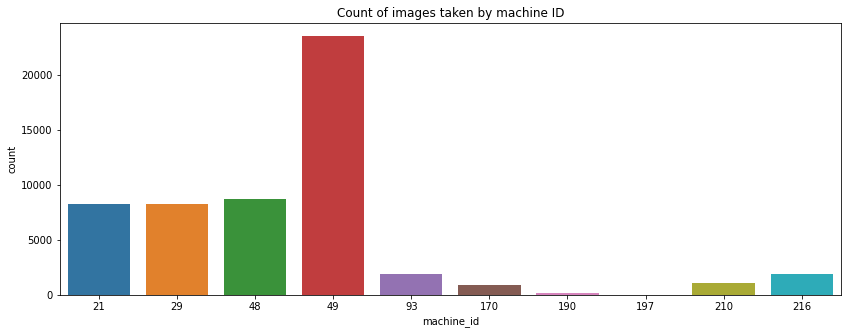

In [35]:
plt.figure(figsize=(14, 5))
sns.countplot(data['machine_id'])
plt.title("Count of images taken by machine ID")
plt.show()

# Target Feature

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


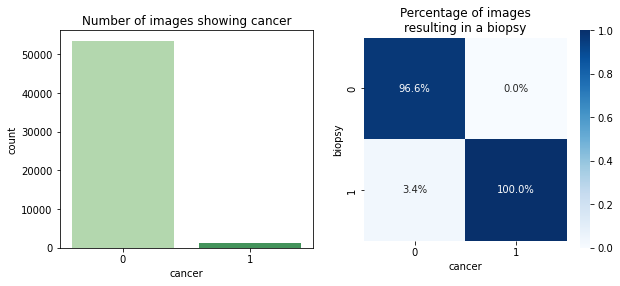

In [36]:
biopsy_counts = data.groupby('cancer')['biopsy'].value_counts().unstack().fillna(0)
biopsy_perc = biopsy_counts.transpose() / biopsy_counts.sum(axis=1)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.countplot(data['cancer'], palette='Greens', ax=ax[0])
sns.heatmap(biopsy_perc, square=True, annot=True, fmt='.1%', cmap='Blues', ax=ax[1])
ax[0].set_title("Number of images showing cancer")
ax[1].set_title("Percentage of images\nresulting in a biopsy")
plt.show()

In [37]:


source = '../input/rsna-breast-cancer-256-pngs/'
data['path'] = source + data['patient_id'].astype(str) + "_" + data['image_id'].astype(str) + ".png"



In [51]:
patients = data[data.machine_id == 49].patient_id.unique()

means, medians, stds, skews, paths, labels = [], [], [], [], [], []

for i in trange(len(patients)):
    path = data[data['patient_id'] == patients[i]]['path'].iloc[0]
    label = data[data['patient_id'] == patients[i]]['cancer'].iloc[0]
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    means.append(np.mean(mp))
    medians.append(np.median(img))
    stds.append(np.std(img))
    skews.append(skew(img, axis=None))
    paths.append(path)
    labels.append(label)
    
stats = pd.DataFrame()
stats['mean'] = means
stats['median'] = medians
stats['std'] = stds
stats['skew'] = skews
stats['path'] = paths
stats['cancer'] = labels
stats.head()

  0%|          | 0/4589 [00:00<?, ?it/s]

TypeError: unsupported operand type(s) for /: 'MammographyPreprocessor' and 'int'

In [ ]:
mammo

In [38]:
source = '/kaggle/working/train_images/'
data['path'] = source + data['patient_id'].astype(str) + "_" + data['image_id'].astype(str) + ".png"


In [48]:
## defining a frame for image and mask storage
framObjTrain = {'img' : [],
           'mask' : []
          }

## defining data Loader function
def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)
    
    names = []
    maskNames = []
    unames = []
    
    for i in range(len(imgNames)):
        unames.append(imgNames[i].split(')')[0])
    
    unames = list(set(unames))
    
    for i in range(len(unames)):
        names.append(unames[i]+').png')
        maskNames.append(unames[i]+')_mask.png')
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(names)):
        img = plt.imread(imgAddr + names[i])
        mask = plt.imread(maskAddr + maskNames[i])
        
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        
        frameObj['img'].append(img)
        frameObj['mask'].append(mask)
        
    return frameObj

In [50]:
# loading benign samples

framObjTrain = LoadData( framObjTrain, imgPath = data[path]
                         , shape = 256)

KeyError: '/kaggle/input/rsna-breast-cancer-detection/train_images/41718/652595063.dcm'

In [ ]:
# loading malignant samples

framObjTrain = LoadData( framObjTrain, imgPath = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant'
                        , maskPath = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant'
                         , shape = 256)

In [ ]:


## displaying data loaded by our function
plt.figure(figsize = (10, 7))
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.title('Ultra Sound Image')
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.title('Mask for Cancer')
plt.show()



**Model**

In [39]:
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x


# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

In [43]:
import tensorflow as tf
import re

In [45]:
inputs = tf.keras.layers.Input((256, 256, 3))
myTransformer = GiveMeUnet(inputs, droupouts= 0.07)
myTransformer.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [46]:
retVal = myTransformer.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs = 50, verbose = 0)

ValueError: Expect x to be a non-empty array or dataset.

In [ ]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

**Testing**

In [ ]:
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img'][0:16]
    mask = valMap['mask'][0:16]
    #mask = mask[0:16]
    
    imgProc = img [0:16]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
  

    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title(' image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted mask')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual mask')

In [ ]:
sixteenPrediction, actuals, masks = predict16(framObjTrain, myTransformer)
Plotter(actuals[1], sixteenPrediction[1][:,:,0], masks[1])

In [ ]:
Plotter(actuals[2], sixteenPrediction[2][:,:,0], masks[2])

# Saving Model

In [ ]:


myTransformer.save('BreastCancerSegmentor.h5')

